# Read from pickles

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : January 13th  2022


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [3]:
# GPy: Gaussian processes library
import GPy

In [4]:
import pickle

In [5]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [6]:
from datetime import datetime,date

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-01-19'

In [9]:
from astropy.io import fits
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [10]:
from time import sleep

In [11]:
from astropy.time import Time
import astropy.units as u

In [12]:
WL=np.arange(350,1100,2)
NWL=len(WL)
X = WL[:,None]

# Function

In [13]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^holo4_003_.*_(.*)_quickLookExp.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

def file_target(filename):
    m = re.findall('^holo4_003_.*_(.*)_.*_.*_quickLookExp$', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

In [14]:
def file_tag_forsorting_ronchi(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^ronchi170lpmm_.*_(.*)_quickLookExp.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

def file_target_ronchi(filename):
    m = re.findall('^ronchi170lpmm_.*_(.*)_.*_.*_quickLookExp$', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

# Config

In [15]:
DATE="2021-07-07"
DATE2="2021_07_07"

In [16]:
version="v4.0"

# Path

In [17]:
inputfilename="./data/holo-scan-auxtel.pickle"

# Read file

In [18]:
with open(inputfilename, 'rb') as pickle_file:
    data_dict = pickle.load(pickle_file)

In [19]:
# data_dict.keys()

In [20]:
list_of_filenames = sorted(data_dict.keys())

In [21]:
# data_dict.values()

In [22]:
#for item in data_dict.items():
#...     print(item)

In [23]:
item = data_dict[list_of_filenames[0]]

In [24]:
len(item['all_lambdas'])

914

In [25]:
len(item['all_fluxes'])

914

In [26]:
N=len(list_of_filenames)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

 bad holo4_003_empty_HD160617_20210707_000276_quickLookExp_spectrum.fits
 bad holo4_003_empty_HD160617_20210707_000284_quickLookExp_spectrum.fits
 bad holo4_003_empty_HD160617_20210707_000289_quickLookExp_spectrum.fits
 bad holo4_003_empty_HD160617_20210707_000291_quickLookExp_spectrum.fits


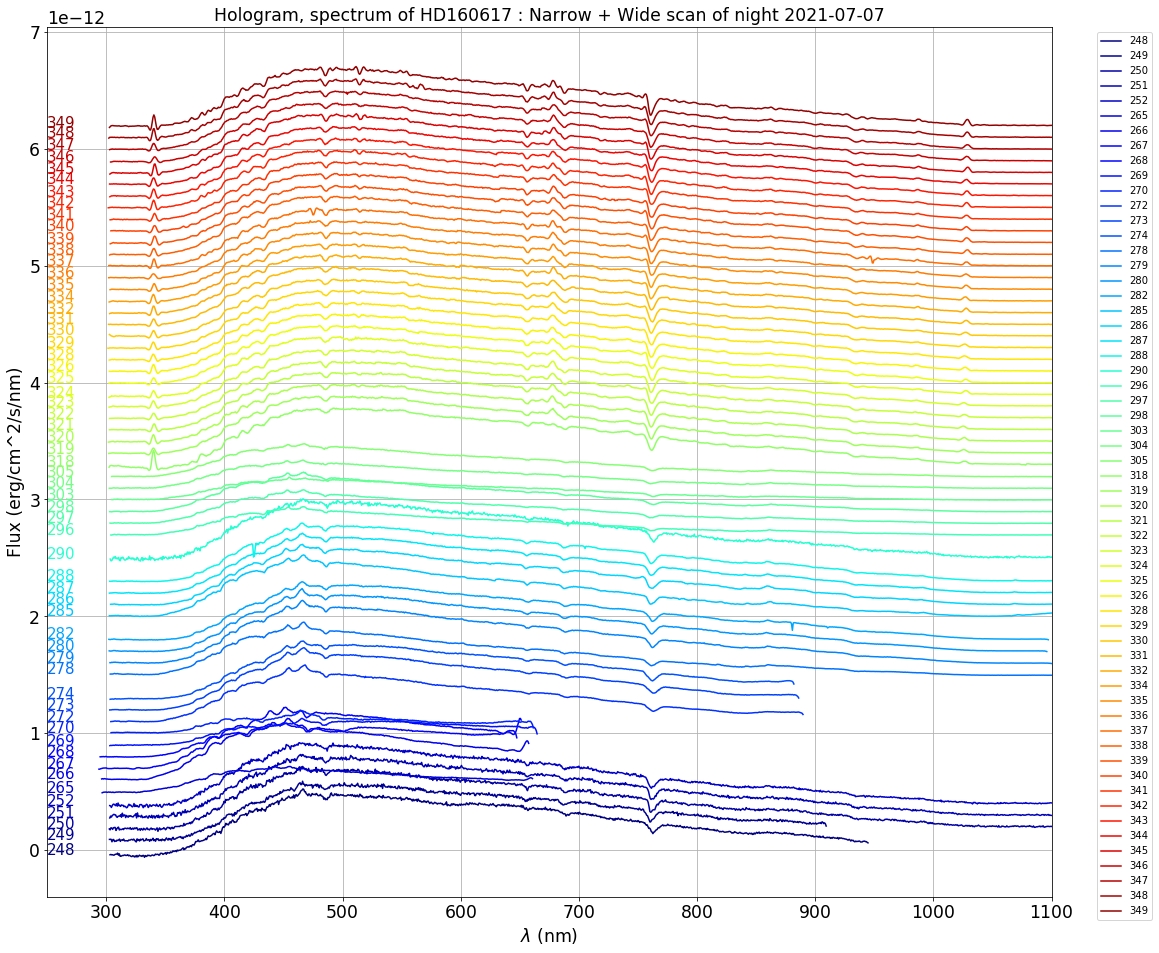

In [27]:
fig=plt.figure(figsize=(18,16))
ax=fig.add_subplot(1,1,1)

idx=0
for filename in list_of_filenames:
    
         
    item  = data_dict[filename]
    lambdas = np.array(item['all_lambdas'])
    fluxes  = np.array(item['all_fluxes'])
    label = int(item['number'])
    
    
    
    delta=idx*1.0e-13
    #delta=0
    
    if len(lambdas) == len(fluxes) and label not in [284, 276, 289, 291] :
        try:
            ax.plot(lambdas,fluxes+delta,label=label,color=all_colors[idx])
            ax.text(250.,fluxes[0]+delta, f'{label}',color=all_colors[idx],fontsize=15)
        except TypeError:
            pass
    else:
        print(f" bad {filename}")
    
    idx+=1
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Flux (erg/cm^2/s/nm)")
ax.set_xlim(250.,1100)
ax.grid()
ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
ax.set_title("Hologram, spectrum of HD160617 : Narrow + Wide scan of night 2021-07-07")
plt.show()
    

# Gaussian process

In [28]:
def fitGPyTransmission(wl,eff,efferr,errorfactor=1,flag_fixnoise=False):
    
    wl=np.array(wl)
    eff=np.array(eff)
    eeff=np.array(efferr)*errorfactor
    
    variance = np.mean(np.sum(eeff**2))
    
    N=len(wl)
    
    
    #kernel = GPy.kern.RBF(1, variance=1e-12, lengthscale=3.0, name="rbf") 
    kernel = GPy.kern.Matern32(1, variance=1e-12, lengthscale=1., name="Matern32")
    
    
    
    X_train = wl[:, None]
    Y_train = eff[:, None] 
    EY_train = (eeff**2)[:,None]
    X = WL[:, None]
    
    m = GPy.models.GPRegression(X_train, Y_train, kernel,noise_var=variance)
    
    
    
    # Constrain the regression parameters to be positive only
    #m.constrain_positive()
    
    #specify noise on points
    #m.Gaussian_noise = variance  # put noise here
    if flag_fixnoise:
        m.Gaussian_noise.variance.fix() # does not optimize noise on points
    
    # optimize other parameters
    m.optimize(messages=True)
    
    mean_prediction, cov_prediction = m.predict_noiseless(X, full_cov=True)
    
    #m = GPy.models.GPRegression(X_train, Y_train, kernel,noise_var=variance)
    # Covariance between training sample points (+ Gaussian noise)
    #Kxx = kernel.K(X_train,X_train) + 1 * np.diag(eeff**2)

    # Covariance between training and test points
    #Ksx = kernel.K(X, X_train)

    # Covariance between test points
    #Kss = kernel.K(X,X)

    # The mean of the GP fit (note that @ is matrix multiplcation: A @ B is equivalent to np.matmul(A,B))
    #mean = Ksx @ np.linalg.inv(Kxx) @ Y_train
    # The covariance matrix of the GP fit
    #Cov = Kss - Ksx @ np.linalg.inv(Kxx) @ Ksx.T
    
   
    return mean_prediction, cov_prediction, m

In [29]:
def plot_gpy(X, m, C, mycolor="b",training_points=None,errorfactor=1,ax=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    
    
    if ax == None:
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(1,1,1)
    
    # Plot 95% confidence interval 
    ax.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.2,facecolor=mycolor)
    # Plot GP mean and initial training points
    ax.plot(X, m, "-",color=mycolor)
    ax.legend(labels=["GP fit"])
    
    ax.set_xlabel("$\lambda$ (nm)") 
    ax.set_ylabel("transmission efficiency")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ , EY_ = training_points
        if EY_.all() == None :
            ax.plot(X_, Y_, "+", color=mycolor,mew=2)
        else:
            ax.errorbar(X_, Y_,yerr = EY_*errorfactor , marker="+",color=mycolor,ecolor="grey",lw=1)
            
        ax.legend(labels=["GP fit", "sample points"])
    ax.set_ylim(0.,1e-12)    
    ax.set_title(f"GP regression on efficiency at position {idx_sel} , errorfactor = {errorfactor}")

In [30]:
idx_sel =0
ERRORFACTOR = 10.0

In [31]:
item  = data_dict[filename]
lambdas = np.array(item['all_lambdas'])
fluxes  = np.array(item['all_fluxes'])
fluxes_err = np.array(item['all_fluxes_err'])
label = int(item['number'])   

<ErrorbarContainer object of 3 artists>

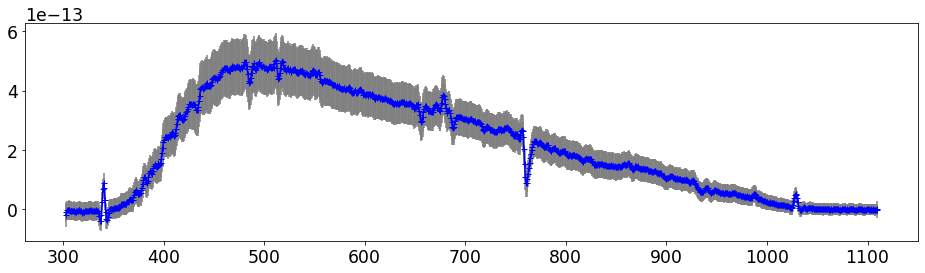

In [32]:
plt.errorbar(lambdas,fluxes,yerr=fluxes_err*ERRORFACTOR,marker="+",color="b",ecolor="grey")

In [33]:
mean, Cov , model = fitGPyTransmission(lambdas,fluxes,fluxes_err,errorfactor=ERRORFACTOR)

In [34]:
display(model)

GP_regression.,value,constraints,priors
Matern32.variance,1.944308433178768e-16,+ve,
Matern32.lengthscale,0.9998482331751947,+ve,
Gaussian_noise.variance,3.88613943843757e-24,+ve,


In [35]:
X_train = lambdas[:,None]
Y_train = fluxes[:,None]
EY_train = fluxes_err[:,None]
X = WL[:,None]

 /users/dagoret/anaconda3/envs/python_3_gpss2021/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning:Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


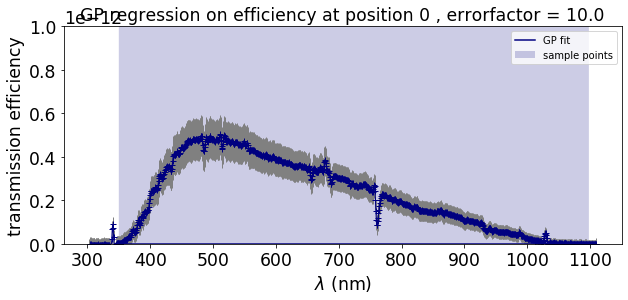

In [36]:
plot_gpy(X, mean, Cov, mycolor=all_colors[0],training_points=(X_train,Y_train,EY_train),errorfactor=ERRORFACTOR)

In [ ]:
fig=plt.figure(figsize=(18,16))
ax=fig.add_subplot(1,1,1)

idx_sel=0
for filename in list_of_filenames:
    
         
    item  = data_dict[filename]
    lambdas = np.array(item['all_lambdas'])
    fluxes  = np.array(item['all_fluxes'])
    fluxes_err = np.array(item['all_fluxes_err'])
    label = int(item['number'])
    
    
    
    mean, Cov , model = fitGPyTransmission(lambdas,fluxes,fluxes_err)
    
    delta=idx_sel*2.0e-12
    
    
    X_train = lambdas[:,None]
    Y_train = fluxes[:,None]
    EY_train = fluxes_err[:,None]
    X = WL[:,None]
    
    plot_gpy(X, mean + delta, Cov, mycolor=all_colors[idx_sel],training_points=(X_train,Y_train,EY_train),errorfactor=1,ax=ax)
    #delta=0
    
    if len(lambdas) == len(fluxes) and label not in [284, 276, 289, 291] :
        try:
            ax.plot(lambdas,fluxes+delta,label=label,color=all_colors[idx_sel])
            ax.text(250.,fluxes[0]+delta, f'{label}',color=all_colors[idx_sel],fontsize=15)
        except TypeError:
            pass
    else:
        print(f" bad {filename}")
    
    idx_sel+=1
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Flux (erg/cm^2/s/nm)")
ax.set_xlim(250.,1100)
ax.grid()
ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
ax.set_title("Hologram, spectrum of HD160617 : Narrow + Wide scan of night 2021-07-07")
plt.show()
    

 /users/dagoret/anaconda3/envs/python_3_gpss2021/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning:Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


 bad holo4_003_empty_HD160617_20210707_000276_quickLookExp_spectrum.fits


 bad holo4_003_empty_HD160617_20210707_000284_quickLookExp_spectrum.fits


 bad holo4_003_empty_HD160617_20210707_000289_quickLookExp_spectrum.fits


 bad holo4_003_empty_HD160617_20210707_000291_quickLookExp_spectrum.fits
